In [ ]:
# Import necessary libraries
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from google.auth.transport.requests import Request
from google.auth.credentials import AnonymousCredentials
from google.oauth2.service_account import Credentials
from google.cloud import bigquery
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nth-victory-359310-450e996fc246.json to nth-victory-359310-450e996fc246.json


In [ ]:
# Authenticate to Google Cloud
auth.authenticate_user()
credentials, project_id = default()
project_id = 'nth-victory-359310'

# Use the JSON key file to authenticate
creds = Credentials.from_service_account_file('nth-victory-359310-450e996fc246.json')

# Create BigQuery client
client = bigquery.Client(credentials=creds, project=project_id)

# Define the SQL query
query = """
  SELECT
      o.order_id,
      oi.product_id,
      oi.user_id,
      p.category,
      p.name AS product_name,
      brand,
      p.department,
      o.created_at,
      o.status,
      oi.sale_price,
      p.cost,
      u.age,
      u.gender,
      u.state,
      u.country,
  FROM
      `bigquery-public-data.thelook_ecommerce.orders` AS o
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi-- combine data from order_items
      ON o.order_id = oi.order_id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.users` AS u -- receive user profile
      ON oi.user_id = u.id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` AS p -- receive product info
      ON oi.product_id = p.id
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` AS ii -- receive inventory info
      ON oi.inventory_item_id = ii.id
  ORDER BY
      o.created_at DESC
  LIMIT 20000 -- Limitation Data for Modelling
  """
# Query the data and convert to DataFrame
df_raw = client.query(query).to_dataframe()

In [ ]:
# Display information about the DataFrame
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   order_id      20000 non-null  Int64              
 1   product_id    20000 non-null  Int64              
 2   user_id       20000 non-null  Int64              
 3   category      20000 non-null  object             
 4   product_name  19999 non-null  object             
 5   brand         19975 non-null  object             
 6   department    20000 non-null  object             
 7   created_at    20000 non-null  datetime64[us, UTC]
 8   status        20000 non-null  object             
 9   sale_price    20000 non-null  float64            
 10  cost          20000 non-null  float64            
 11  age           20000 non-null  Int64              
 12  gender        20000 non-null  object             
 13  state         20000 non-null  object             
 14  countr

In [ ]:
# Create a copy of df_raw
df = df_raw.copy()
df.head()

,order_id,product_id,user_id,category,product_name,brand,department,created_at,status,sale_price,cost,age,gender,state,country
0,124135,9449,99202,Socks & Hosiery,Donna Karan The Signature Collection Sueded Je...,Donna Karan,Women,2024-08-14 19:15:16.531312+00:00,Complete,54.000000,21.11400,23,F,Sichuan,China
1,124134,1982,99202,Fashion Hoodies & Sweatshirts,Allegra K Ladies Long Sleeve Drawstring Plush ...,Allegra K,Women,2024-08-14 19:15:16.531312+00:00,Processing,20.299999,9.82520,23,F,Sichuan,China
2,124136,597,99202,Tops & Tees,Selena Gomez When The Sun Goes Down Black Tiss...,Selena Gomez,Women,2024-08-14 19:15:16.531312+00:00,Shipped,21.000000,12.36900,23,F,Sichuan,China
3,124134,14022,99202,Accessories,Scala Women's Stretch Chenille Glove,Scala,Women,2024-08-14 19:15:16.531312+00:00,Processing,7.990000,3.48364,23,F,Sichuan,China
4,124134,9893,99202,Sleep & Lounge,DreamSacks BambooDreams Cleo Pajama Set,DreamSacks,Women,2024-08-14 19:15:16.531312+00:00,Processing,98.000000,54.29200,23,F,Sichuan,China


In [ ]:
# checking null in product_name
df[df['brand'].isnull()]

,index,order_id,product_id,user_id,category,product_name,brand,department,created_at,status,sale_price,cost,age,gender,state,country,month_year,age_group


# Pre-Processing

In [ ]:
# Checking duplicates
df.duplicated().sum()

0

In [ ]:
# Checking Nilai Null
df.isnull().sum()

,0
order_id,0
product_id,0
user_id,0
category,0
product_name,1
brand,25
department,0
created_at,0
status,0
sale_price,0


To handle null values in the product_name and brand columns, I will fill them using the product_name that matches the existing product_id. If they remain null, I will fill them with 'No Product Name' and 'No Brand'.

In [ ]:
# Mengisi nilai null pada 'product_name' berdasarkan 'product_id'
df['product_name'] = df.groupby('product_id')['product_name'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No Product Name'))


In [ ]:
df['brand'] = df.groupby('product_id')['brand'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No Brand'))

I’m filtering out data with 'cancelled' and 'returned' statuses because these statuses do not affect the company's revenue.

In [ ]:
df = df[~df['status'].isin(['Cancelled', 'Returned'])]


In [ ]:
df = df.head(20000).reset_index()
df

,index,order_id,product_id,user_id,category,product_name,brand,department,created_at,status,sale_price,cost,age,gender,state,country
0,0,124135,9449,99202,Socks & Hosiery,Donna Karan The Signature Collection Sueded Je...,Donna Karan,Women,2024-08-14 19:15:16.531312+00:00,Complete,54.000000,21.114000,23,F,Sichuan,China
1,1,124134,1982,99202,Fashion Hoodies & Sweatshirts,Allegra K Ladies Long Sleeve Drawstring Plush ...,Allegra K,Women,2024-08-14 19:15:16.531312+00:00,Processing,20.299999,9.825200,23,F,Sichuan,China
2,2,124136,597,99202,Tops & Tees,Selena Gomez When The Sun Goes Down Black Tiss...,Selena Gomez,Women,2024-08-14 19:15:16.531312+00:00,Shipped,21.000000,12.369000,23,F,Sichuan,China
3,3,124134,14022,99202,Accessories,Scala Women's Stretch Chenille Glove,Scala,Women,2024-08-14 19:15:16.531312+00:00,Processing,7.990000,3.483640,23,F,Sichuan,China
4,4,124134,9893,99202,Sleep & Lounge,DreamSacks BambooDreams Cleo Pajama Set,DreamSacks,Women,2024-08-14 19:15:16.531312+00:00,Processing,98.000000,54.292000,23,F,Sichuan,China
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,19995,54714,13338,43762,Swim,Coolibar UPF 50+ Women's ZnO Beach Henley Dress,Coolibar,Women,2024-07-08 11:26:00+00:00,Complete,59.990002,27.655391,23,F,Rio de Janeiro,Brasil
15031,19996,40361,16043,32177,Tops & Tees,Fred Perry Men's Paisley Trim Polo,Fred Perry,Men,2024-07-08 11:26:00+00:00,Processing,95.000000,51.205000,21,M,Shanghai,China
15032,19997,81643,962,65339,Sweaters,Ralph Lauren Sport Women Wool/Cashmere V-neck ...,Ralph Lauren,Women,2024-07-08 11:19:00+00:00,Processing,64.989998,29.960389,20,F,Zhejiang,China
15033,19998,110056,17325,88109,Fashion Hoodies & Sweatshirts,Fox Powerlines Sasquatch Fullzip Hoodie,Fox,Men,2024-07-08 11:11:00+00:00,Shipped,39.380001,21.934661,70,M,Alagoas,Brasil


# Exploratory Data Analysis

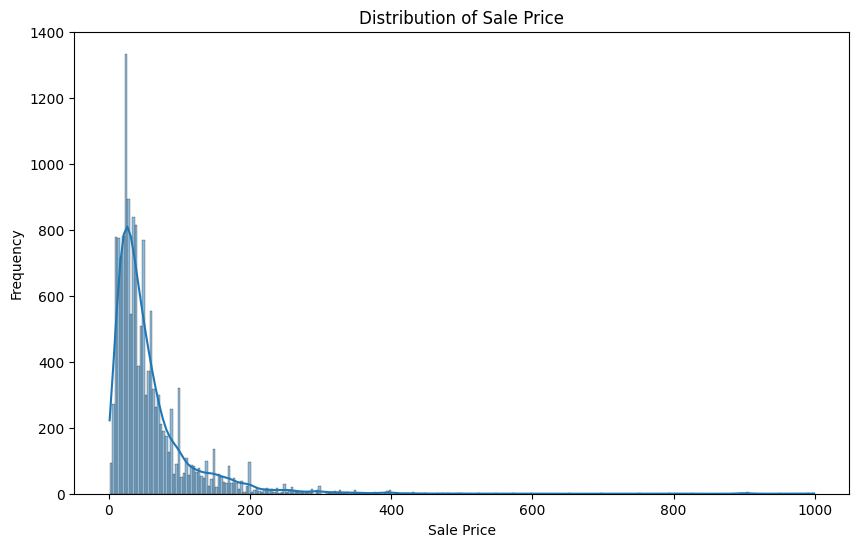

In [ ]:
# Distribution of 'sale_price'
plt.figure(figsize=(10, 6))
sns.histplot(df['sale_price'], kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()


Based on the chart above, most transactions have a relatively low purchase price (0 - 100).

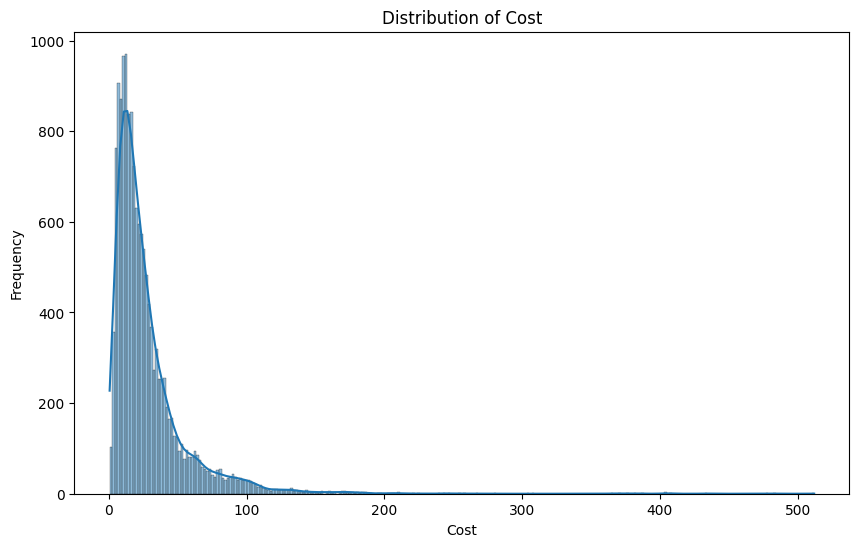

In [ ]:
# Distribution of 'sale_price'
plt.figure(figsize=(10, 6))
sns.histplot(df['cost'], kde=True)
plt.title('Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

Based on the chart above, most cost have a relatively low cost price (0 - 100).

<ipython-input-15-cbdd7d3ee28d>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['created_at'].dt.to_period('M')


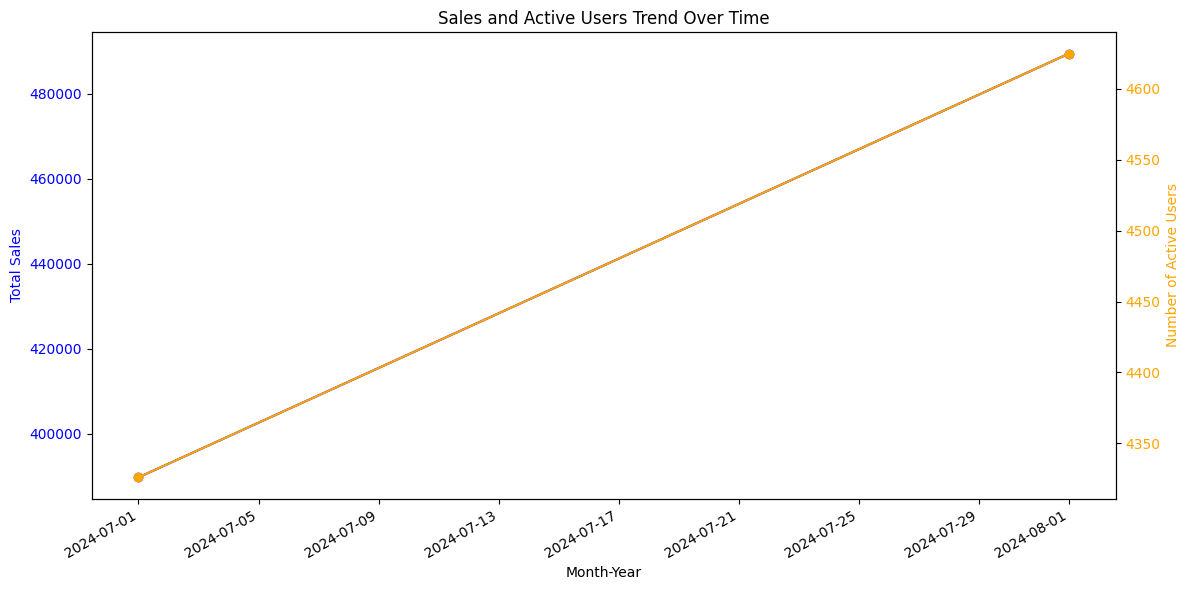

In [ ]:
# Convert 'created_at' to datetime and extract month-year
df['created_at'] = pd.to_datetime(df['created_at'])
df['month_year'] = df['created_at'].dt.to_period('M')

# Calculate monthly sales
monthly_sales = df.groupby('month_year')['sale_price'].sum().reset_index()

# Calculate monthly active users
monthly_users = df.groupby('month_year')['user_id'].nunique().reset_index()

# Plotting the trends with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sales trend on primary y-axis
ax1.plot(monthly_sales['month_year'].dt.to_timestamp(), monthly_sales['sale_price'], marker='o', color='b', label='Total Sales')
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Total Sales', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Sales and Active Users Trend Over Time')

# Create secondary y-axis for active users
ax2 = ax1.twinx()
ax2.plot(monthly_users['month_year'].dt.to_timestamp(), monthly_users['user_id'], marker='o', color='orange', label='Active Users')
ax2.set_ylabel('Number of Active Users', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Rotate x-axis labels for better readability
fig.autofmt_xdate()

# Show plot
plt.tight_layout()
plt.show()

Both total sales and the number of active users exhibit a strong positive correlation. As the number of active users increases, total sales also rise consistently throughout the month.

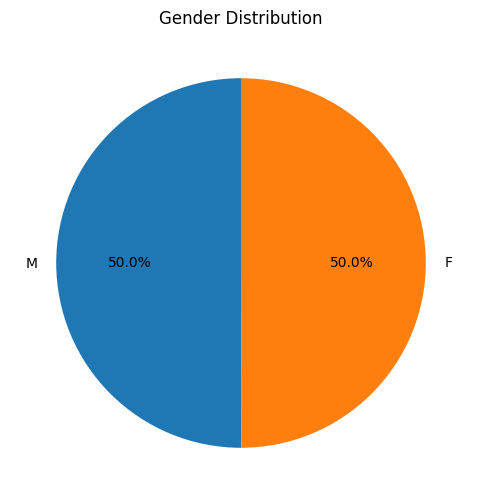

In [ ]:
# Calculate gender distribution
gender_counts = df['gender'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.show()


The distribution of users by gender is very balanced. This indicates that the platform has broad and equal appeal to both genders.

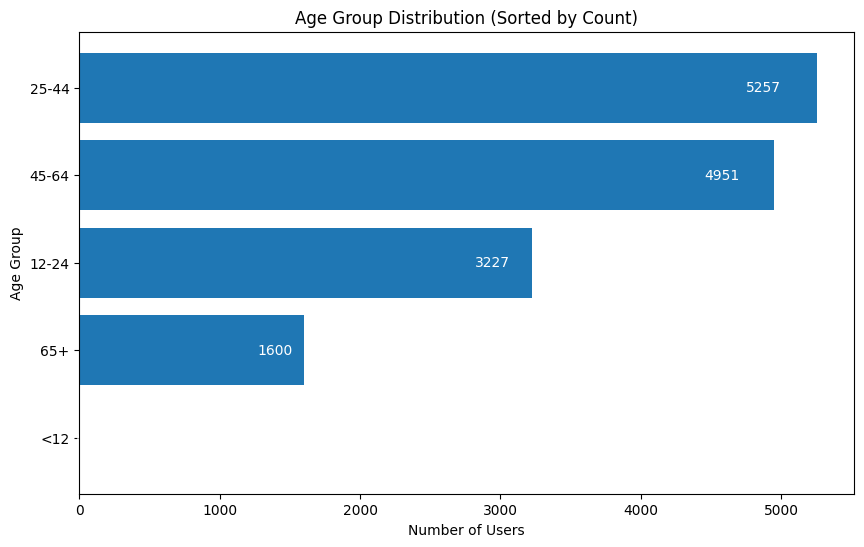

In [ ]:
# Define age groups
age_bins = [0, 12, 25, 45, 65, 100]
age_labels = ['<12', '12-24', '25-44', '45-64', '65+']

# Categorize ages into groups
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate age group distribution
age_group_counts = df['age_group'].value_counts()

# Sort age groups by count in descending order
age_group_counts = age_group_counts.sort_values(ascending=True)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(age_group_counts.index, age_group_counts.values)

# Add data labels inside the bars
for bar in bars:
    plt.text(bar.get_width() - 0.05 * bar.get_width(),  # Position label inside bar, near the end
             bar.get_y() + bar.get_height() / 2,
             f'{int(bar.get_width())}',
             va='center',
             ha='right',
             color='white')

plt.xlabel('Number of Users')
plt.ylabel('Age Group')
plt.title('Age Group Distribution (Sorted by Count)')
plt.show()

The majority of customers are in the age range of 25-44.

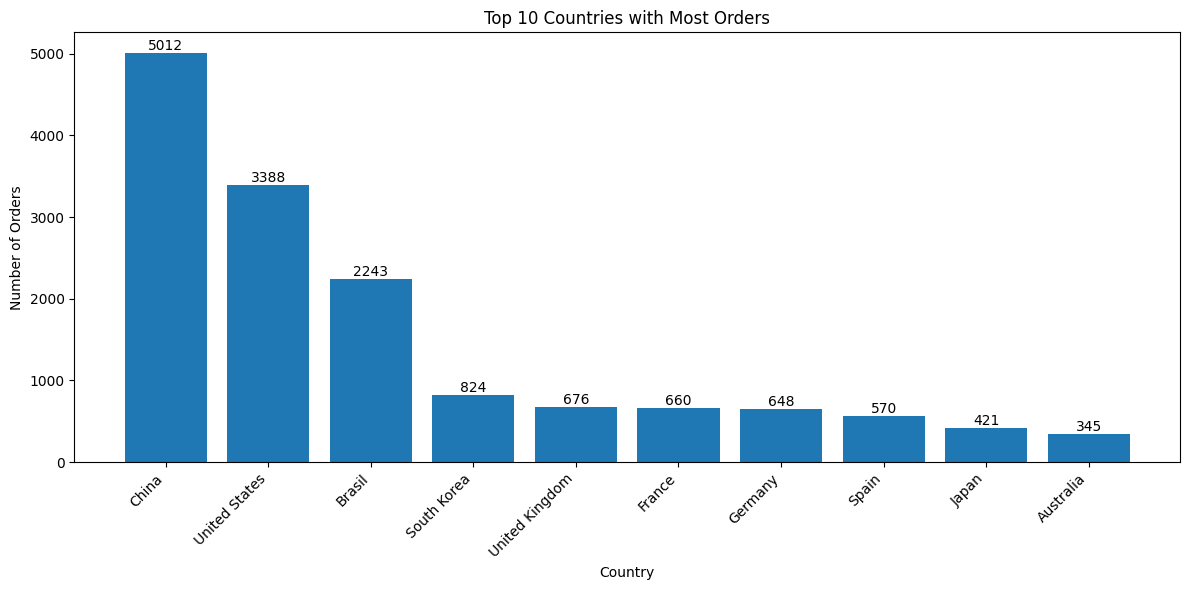

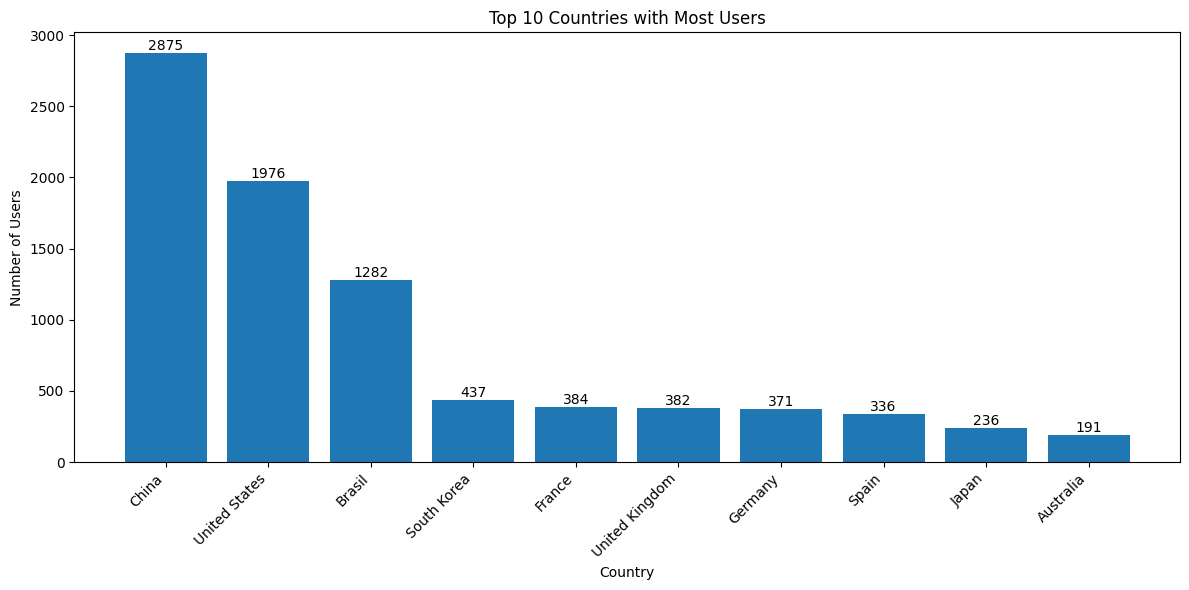

In [ ]:
# Top 10 Countries with Most Orders
top_order_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_order_countries.index, top_order_countries.values)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             str(int(bar.get_height())),
             ha='center', va='bottom')

plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.title('Top 10 Countries with Most Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top 10 Countries with Most Users
top_user_countries = df.groupby('country')['user_id'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_user_countries.index, top_user_countries.values)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             str(int(bar.get_height())),
             ha='center', va='bottom')

plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title('Top 10 Countries with Most Users')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


China is the country with the highest number of transactions and users.

# Feature Engineering

In [ ]:
# One Hot Encoding for categorical column
encoder = OneHotEncoder(sparse=False)
ohe_matrix = encoder.fit_transform(df[['category', 'brand', 'department']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# TF-IDF Vectorization for product name
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['product_name'])

In [ ]:
# Combine OHE and TF-IDF
combined_matrix = hstack([tfidf_matrix, ohe_matrix])

# Calculate cosine from combined matrix
cosine_sim = cosine_similarity(combined_matrix, combined_matrix)

# Modeling : Content Based Recommendation System With FuzzyWuzzy

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import process

# Step 5: Fungsi untuk mendapatkan rekomendasi dengan FuzzyWuzzy
def get_recommendations_fuzzywuzzy(product_name, cosine_sim=cosine_sim, top_n=10):
    # Mencari nama produk yang paling mirip menggunakan FuzzyWuzzy
    matching_string, score, index_matching = process.extractOne(product_name, df['product_name'])

    # Check if the closest match has a sufficient score (you can adjust this threshold)
    if score < 80:
        return f"No close match found for '{product_name}'."

    # Mencari indeks produk berdasarkan nama
    idx = df.index[df['product_name'] == matching_string][0]

    # Mendapatkan skor kesamaan untuk semua produk dengan produk yang diberikan
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan produk berdasarkan skor kesamaan (dari tertinggi ke terendah)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mendapatkan indeks produk yang paling mirip
    sim_scores = sim_scores[1:top_n+1]

    # Mengembalikan rekomendasi produk
    product_indices = [i[0] for i in sim_scores]
    return df[['product_name', 'category', 'brand', 'department', 'sale_price']].iloc[product_indices].reset_index().drop(columns=['index'])

In [ ]:
# Contoh penggunaan
input_product_name = input("Masukkan nama produk yang ingin dicari: ")
recommended_data = get_recommendations_fuzzywuzzy(input_product_name)
recommended_data

Masukkan nama produk yang ingin dicari: legging


,product_name,category,brand,department,sale_price
0,AG Adriano Goldschmied Women's Velvet Corduroy...,Leggings,AG Adriano Goldschmied,Women,178.000000
1,AG Adriano Goldschmied Women's Skinny Fit Legg...,Jeans,AG Adriano Goldschmied,Women,157.990005
2,AG Adriano Goldschmied Women's Relaxed Pullover,Sweaters,AG Adriano Goldschmied,Women,51.740002
3,AG Adriano Goldschmied Women's Super Skinny Jean,Jeans,AG Adriano Goldschmied,Women,176.000000
4,AG Adriano Goldschmied Women's Daisy Cut-Off S...,Shorts,AG Adriano Goldschmied,Women,25.000000
5,AG Adriano Goldschmied Women's Cut-Off Daisy S...,Shorts,AG Adriano Goldschmied,Women,155.000000
6,AG Adriano Goldschmied Women's Cut-Off Daisy S...,Shorts,AG Adriano Goldschmied,Women,155.000000
7,AG Adriano Goldschmied Women's Ballad Slim Boo...,Jeans,AG Adriano Goldschmied,Women,172.000000
8,AG Adriano Goldschmied Women's Farrah High Ris...,Shorts,AG Adriano Goldschmied,Women,61.240002
9,AG Adriano Goldschmied Women's Stilt Cigarette...,Jeans,AG Adriano Goldschmied,Women,164.000000
